In [1]:
pwd

'/Users/edwardterrell/Desktop/covid_machinations'

In [2]:
# this block is used for copying/moving files
import os
import shutil
import time
#shutil.copyfile('src', 'dst')
#shutil.move

# we want to ensure we are in the correct conda environment
import sys
sys.executable

'/Users/edwardterrell/opt/anaconda3/envs/mlx/bin/python'

In [3]:
# provides ability to reload modules (wihtout leaving jupyter) if changes are made
#import importlib
#importlib.reload(scd)

In [4]:
import numpy as np
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup as bs
# import regular expressions
import re 

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

### Cornavirus section

In [5]:
# This is a custom python module with dictionaries of states and countries; 
# it also contains three functions repair_dict, reverse_dict, and custom_list
import state_country_dicts as scd

# get current date for use in creating filenames with embedded 'day'. 
# convert datetime object to string
import datetime as dt
today  = dt.date.today()
day = today.strftime('%Y-%m-%d')
day

'2022-03-20'

In [6]:
print ('If using Binder enter a timezone difference from UTC')
timezone = input(' Enter a number between 12 and -12:')
print(timezone)
if timezone:
    timezone = int(timezone)
    v = scd.tz_dict[timezone]
    t = pd.Timestamp.today(v)
    print (t)
    day = t.date().strftime('%Y-%m-%d')
day

If using Binder enter a timezone difference from UTC


 Enter a number between 12 and -12: 


'2022-03-20'

### Moves all files from covid_data_update to covid_data 

In [7]:
# Ensure helper files used in past have been removed
!rm -f covid_data/covid_text covid_data/flist_of_covid_png covid_data/temp.xlsx
!rm -f covid_text flist_of_covid_png temp.xlsx

!mkdir covid_data_update

In [8]:
# House keeping covid_data_update folder
# preparing the move of all files from covid_data_update to covid_data 
# so that we are left with an empty covid_date_update folder
file_names = []
source_dir = 'covid_data_update'
target_dir = 'covid_data'
print("covid_data_update directory contents:") 
file_names = os.listdir(source_dir)
print (file_names)
if file_names == []:
    print ('Directory is empty so no files available to move')

covid_data_update directory contents:
[]
Directory is empty so no files available to move


In [9]:
# The below will move and archive all files in covid_data_update to covid_data

# Move contents of source ('covid_data_update')to target ('covid_data')
for file_name in file_names:
    try:
        shutil.move(os.path.join(source_dir, file_name), target_dir)
    except:
        print(f'{file_name} already exists in target dir')

In [10]:
def clean_up (number_str):
    '''This is a clean up routine so that only numeric characters remain'''
    number_str = number_str.replace(',', '').replace('null','0').rstrip(']').lstrip("'")
    return int(number_str)

### Custom state dictionaries

In [11]:
# creates a custom state dict
s_string = input('Enter state codes seperated by a space:') or 'ca ny il'
print()

slist = scd.custom_list (s_string)
state_dict = {key: value for key, value in scd.all_states.items() if value in slist}
state_dict

Enter state codes seperated by a space: 


{'california': 'CA', 'illinois': 'IL', 'new-york': 'NY'}

### Add state and world population data

In [12]:
# create dataframes
all_state_pop = pd.read_csv('state_pop.csv').iloc[:,1:3].set_index('Code')
all_state_pop.head()

,pop_millions
Code,
AL,5.024279
AK,0.733391
AZ,7.151502
AR,3.011524
CA,39.538223


In [13]:
# create dataframes
world_pop = pd.read_csv('world_pop.csv').iloc[:,0:2].set_index('country')
temp = (world_pop.population/1000000).round(2)
world_pop['pop_millions'] = temp
world_pop.head()

,population,pop_millions
country,,
China,1440297825,1440.30
India,1382345085,1382.35
United States,331341050,331.34
Indonesia,274021604,274.02
Pakistan,221612785,221.61


### State Scraping section

In [14]:
# The start dates for U.S.states and for countries are different so must be accounted for
st_start = pd.Timestamp('2020/3/13')
c_start = pd.Timestamp('2020/2/16')

# set end date to yesterday

#day == pd.Timestamp.today().strftime('%Y-%m-%d')
end = pd.Timestamp.today() - pd.Timedelta(days=1)
print(f"End date is set to yesterday: {end.strftime('%Y-%m-%d')}")
    
# set the index to the appropriate date range for states and countries
st_index = pd.date_range(st_start, end)
c_index = pd.date_range(c_start, end)
len(st_index)
len(c_index)

# list comprehension to extract just the state initials from the dict
st_list = list(state_dict.values())

# create an empty pandas df with column headers from state_dict
state = pd.DataFrame(columns = st_list,index=st_index)
state.sort_index(ascending = False).head()
state.shape

End date is set to yesterday: 2022-03-19


737

763

,CA,IL,NY
2022-03-19,NaN,NaN,NaN
2022-03-18,NaN,NaN,NaN
2022-03-17,NaN,NaN,NaN
2022-03-16,NaN,NaN,NaN
2022-03-15,NaN,NaN,NaN


(737, 3)

In [15]:
state_url='https://www.worldometers.info/coronavirus/usa/'
# Here the keys are the state names and the values are the 2-letter abbreviation
for key, value in state_dict.items():
    url = state_url+key
    print(url)

    # scrape web page for state info and assign to soup
    response = requests.get(url)
    #response.status_code
    page = response.text
    soup = bs(page)
    
    # Find block of text/data near 'graph-cases-daily' 
    re_graph = re.compile('graph-cases')
    try:
        data = soup.find(text=re_graph).parent
    except:
        print(f'Unable to find {url}')
        print()
        break
    

    # Regex to pull out data chunk out of the larger soup like data
    myregex = re.compile (r'data:.*\]')
    mo = myregex.search(str(data))

    #mo.group() is a string so easy to get rid of the first entry
    #state_previous_cases is a list of daily new coronavirus cases
    state_previous_cases = mo.group().split(',')[1:]
    len(state_previous_cases)
    
    # ensure match between length of the empty df and the new list
    if len(st_index)!= len(state_previous_cases):
        print (len(st_index))
        print (len(state_previous_cases))
        state_previous_cases = state_previous_cases[:-1]
        print (len(state_previous_cases))
    
    # merge states into the existing df and apply the function clean_up to convert strings to ints
    # state[value] where value is the 2-letter abreviation
    state[value] = state_previous_cases
    state[value] = state[value].fillna(0).apply(clean_up)
    
    time.sleep(2)
state.sort_index(ascending = False).head()   

https://www.worldometers.info/coronavirus/usa/california


737

https://www.worldometers.info/coronavirus/usa/illinois


737

https://www.worldometers.info/coronavirus/usa/new-york


737

,CA,IL,NY
2022-03-19,727,0,2379
2022-03-18,4224,1388,2143
2022-03-17,5588,1150,2327
2022-03-16,2656,1031,1977
2022-03-15,2280,1574,3305


In [16]:
# Create df of new_cases/million population
cols = state.columns.to_list()
print(cols)

# Extract just the poopulations for the states of interest
pop_series = all_state_pop.loc[cols].pop_millions
pop_series

['CA', 'IL', 'NY']


Code
CA    39.538223
IL    12.801989
NY    20.201249
Name: pop_millions, dtype: float64

In [17]:
state_cases_by_million = (state/pop_series).round()
state_cases_by_million.tail(7)

,CA,IL,NY
2022-03-13,87.0,41.0,79.0
2022-03-14,75.0,54.0,77.0
2022-03-15,58.0,123.0,164.0
2022-03-16,67.0,81.0,98.0
2022-03-17,141.0,90.0,115.0
2022-03-18,107.0,108.0,106.0
2022-03-19,18.0,0.0,118.0


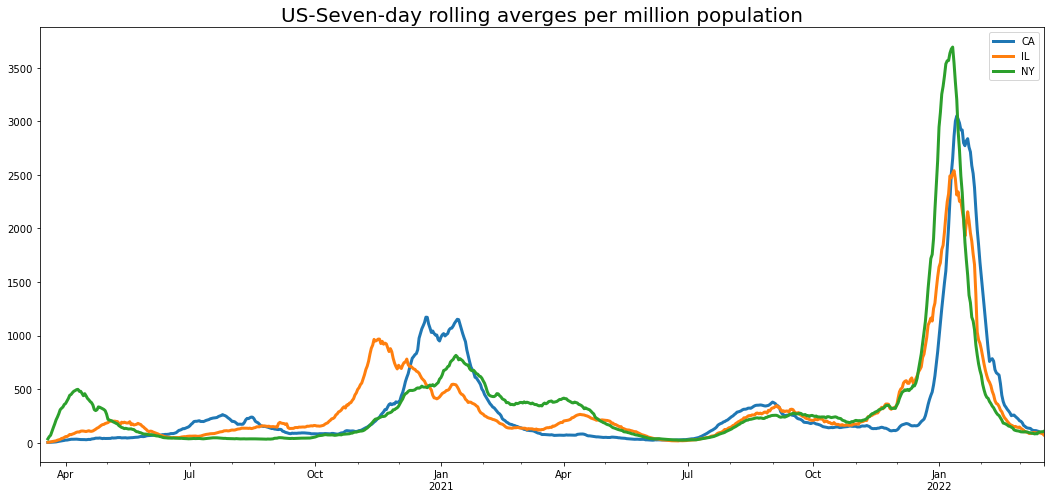

In [18]:
# Plot 7-day moving averge per million population
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data_all = state_cases_by_million.rolling(window=7).mean()
roll_data_all.plot(ax=ax, linewidth=3);
plt.title('US-Seven-day rolling averges per million population',fontsize=20);
#plt.savefig(f'./covid_data_update/us_rolling_avg_per_million_{day}.png');

In [19]:
def list2string(l): 
    ''' This creates a a short string of state/country names 
    used during file save
    '''
    str1 = "_" 
    # return string  
    return (str1.join(l))

States available: ['CA', 'IL', 'NY']



Choose state for rolling averge: 


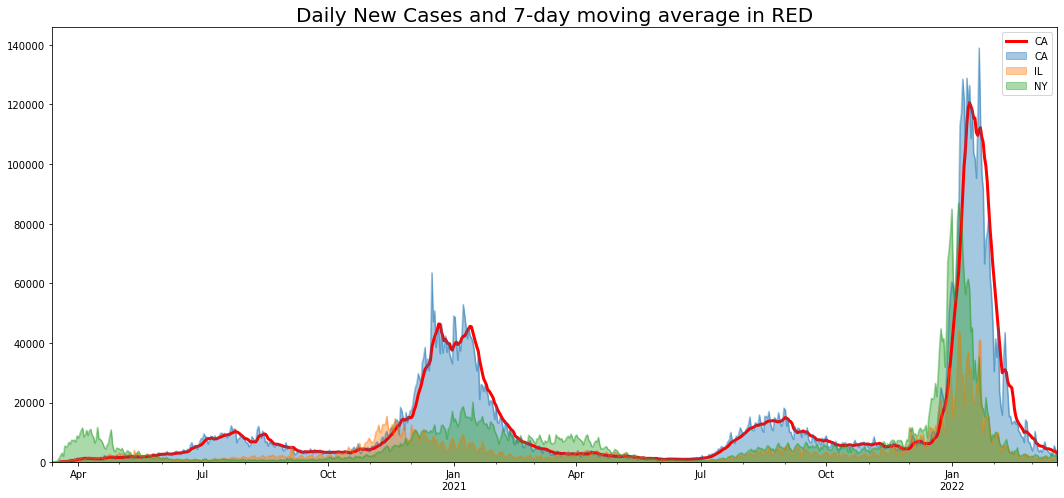

In [20]:
# Allows user to select state for rolling average 
s_available = list(state.columns)
print(f'States available: {s_available}')
print()

snames = (list2string(s_available))

select_state = input('Choose state for rolling averge:')or s_available[0]
select_state = select_state.upper()

if select_state not in s_available:
    select_state = s_available[0]

# Plot Daily New Cases and 7-day moving averge
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data = state.loc[:,[select_state]].rolling(window=7).mean()

roll_data.plot(ax=ax, linewidth=3, color='r')
state.plot(kind='area',alpha=.4,ax=ax,stacked=False);
plt.title('Daily New Cases and 7-day moving average in RED', fontsize=20) 

#ax.set_title('Daily New Cases and 7-day moving average in RED', fontsize=20) 
plt.savefig(f'./covid_data_update/us_{day}.png');

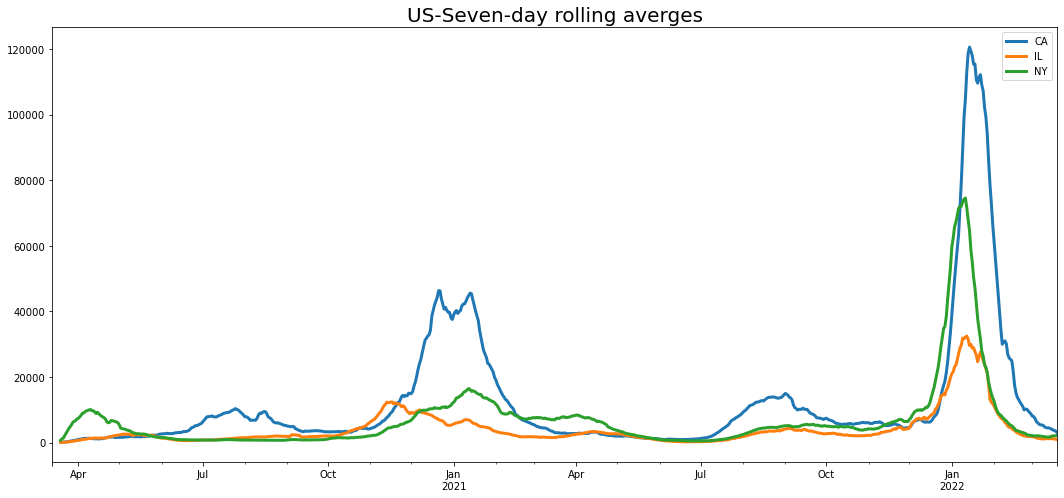

In [21]:
# Plot 7-day moving averge
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data_all = state.rolling(window=7).mean()
roll_data_all.plot(ax=ax, linewidth=3);
plt.title('US-Seven-day rolling averges',fontsize=20)
plt.savefig(f'./covid_data_update/us_rolling_avg_{day}.png');

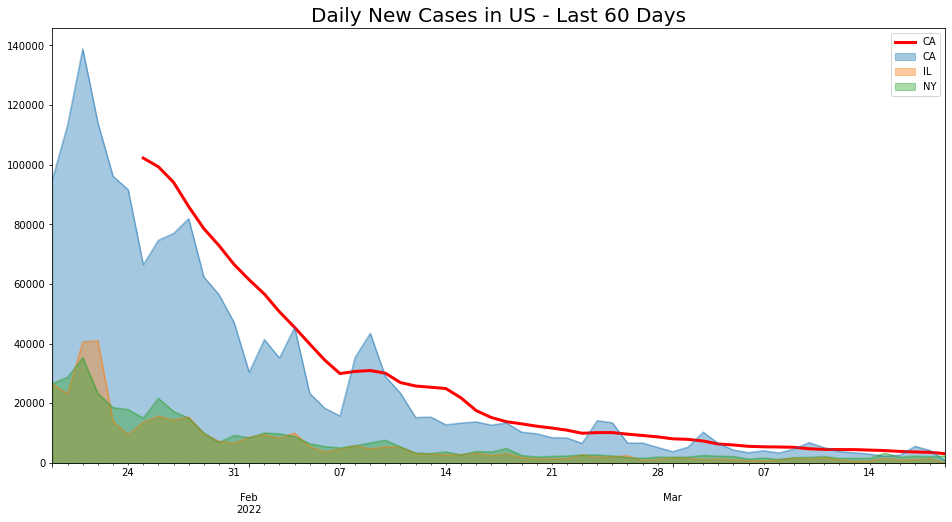

In [22]:
# Plot Last 60 Days
plt.close('all')
# Select last 60 days only
state_last60 = state.tail(60)

roll_data = state_last60.loc[:,[select_state]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
state_last60.plot(kind='area',alpha=.4,ax=ax,stacked=False);

plt.title('Daily New Cases in US - Last 60 Days',fontsize=20)
plt.savefig(f'./covid_data_update/us_{snames}_last_60_days_{day}.png');

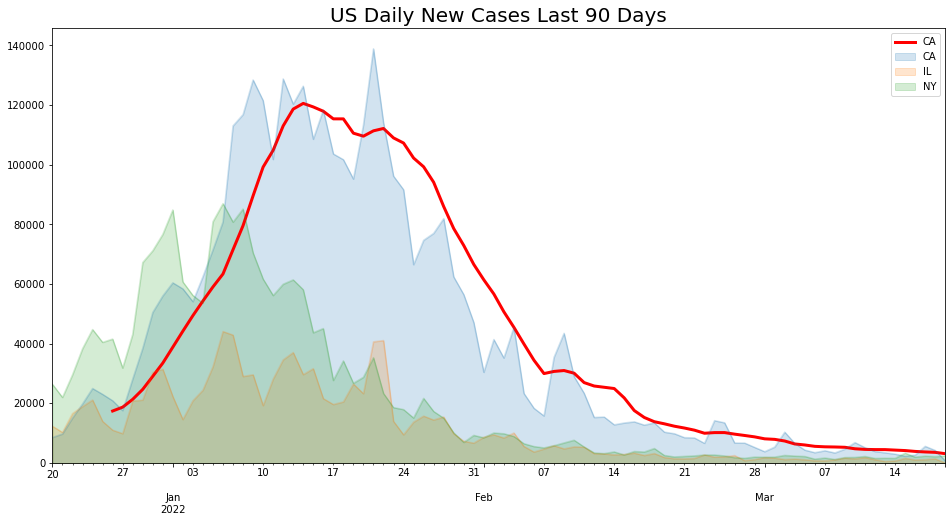

In [23]:
# Plot last 90 days
plt.close('all')
# Select last 90 days only
state_last90 = state.tail(90)

roll_data = state_last90.loc[:,[select_state]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
state_last90.plot(kind='area',alpha=.2,ax=ax,stacked=False);

plt.title('US Daily New Cases Last 90 Days',fontsize=20)
plt.savefig(f'./covid_data_update/us_{snames}_last_90_days_{day}.png');

In [24]:
# Daily New Cases in tabular format
pd.set_option('display.max_rows', 300)
pd.set_option('display.min_rows', 300)
state.sort_index(ascending = False)

,CA,IL,NY
2022-03-19,727,0,2379
2022-03-18,4224,1388,2143
2022-03-17,5588,1150,2327
2022-03-16,2656,1031,1977
2022-03-15,2280,1574,3305
2022-03-14,2985,697,1565
2022-03-13,3431,521,1602
2022-03-12,3851,1106,1543
2022-03-11,5155,1825,2192
2022-03-10,6846,1398,1879


### Custom country dictionaries

In [25]:
#list(scd.all_countries.items())

In [26]:
# creates a custom country dict
c_string = input('Enter country codes seperated by a space:') or 'fr it es'
clist = scd.custom_list (c_string)

country_dict = {key: value for key, value in scd.all_countries.items() if value in clist}
print(country_dict)

print()

Enter country codes seperated by a space: 


{'spain': 'ES', 'france': 'FR', 'italy': 'IT'}



### Scraping section

In [27]:
c_list = list(country_dict.values())
c_list

# create an empty pandas df with column headers from country_dict, using the starting dates for the country as index
country = pd.DataFrame(columns = c_list,index=c_index)
country.sort_index(ascending = False).head()

base_url='https://www.worldometers.info/coronavirus/country/'
# Here the keys are the country names and the values are the 2-letter abbreviation
for key, value in country_dict.items():
    url = base_url+key
    print(url)

    # scrape web page for country info and assign to soup
    response = requests.get(url)
    #response.status_code
    page = response.text
    #print(response.text[:400])
    soup = bs(page)
    
    # Find block of text/data near 'graph-cases-daily' 
    re_graph = re.compile('graph-cases')
    dat = soup.find(text=re_graph)
   
    try:
        data = soup.find(text=re_graph).parent
    except:
        print(f'Unable to find {url}')
        print()
        break

    # Regex to pull out data chunk out of the larger soup like data
    myregex = re.compile (r'data:.*\]')
    mo = myregex.search(str(data))

    #mo.group() is a string so easy to get rid of the first entry
    country_previous_cases = mo.group().split(',')[1:]
    #print(country_previous_cases)
    previous_cases = ["0" if i == 'null' else i for i in country_previous_cases]
    
    len(previous_cases)

    # merge countries into the existing df and apply the function clean_up to convert strings to ints
    country[value] = previous_cases
    country[value] = country[value].fillna(0).apply(clean_up)
    
    time.sleep(2)
country.clip(lower=0,inplace=True) #large negative number removed for better graphic clarity
country.sort_index(ascending = False).head()

['ES', 'FR', 'IT']

,ES,FR,IT
2022-03-19,NaN,NaN,NaN
2022-03-18,NaN,NaN,NaN
2022-03-17,NaN,NaN,NaN
2022-03-16,NaN,NaN,NaN
2022-03-15,NaN,NaN,NaN


https://www.worldometers.info/coronavirus/country/spain


763

https://www.worldometers.info/coronavirus/country/france


763

https://www.worldometers.info/coronavirus/country/italy


763

,ES,FR,IT
2022-03-19,0,98104,75173
2022-03-18,21533,97579,77994
2022-03-17,21532,101747,82222
2022-03-16,21532,108832,75041
2022-03-15,9015,116618,86867


In [28]:
clist

['FR', 'IT', 'ES']

In [29]:
# create a reveresed iso3166 country-code dictionary
iso3166r = scd.reverse_dict(scd.iso3166)

In [30]:
country_dict = {key: value for key, value in scd.iso3166r.items() if value in clist}
w_cols = list(country_dict.keys())

# fix uk entries to match conventional country names
if 'uk' in w_cols:
    w_cols.remove('uk')
    w_cols.append('United Kingdom')
if 'US' in w_cols:
    w_cols.remove('US')
    w_cols.append('United States')
w_cols

['Spain', 'France', 'Italy']

In [31]:
# Extract just the populations for the states of interest
wpop_series = world_pop.loc[w_cols].pop_millions
wpop_series

country
Spain     46.76
France    65.30
Italy     60.45
Name: pop_millions, dtype: float64

In [32]:
wpop_series.index

Index(['Spain', 'France', 'Italy'], dtype='object', name='country')

In [33]:
wpop_series.rename(index=iso3166r, inplace=True)

In [34]:
wpop_series

country
ES    46.76
FR    65.30
IT    60.45
Name: pop_millions, dtype: float64

In [35]:
# repair issues with uk and us
wpop_series.rename({'United Kingdom':'UK','United States':'US'},inplace=True)

In [36]:
world_cases_by_million = (country/wpop_series).round()
world_cases_by_million.tail()

,ES,FR,IT
2022-03-15,193.0,1786.0,1437.0
2022-03-16,460.0,1667.0,1241.0
2022-03-17,460.0,1558.0,1360.0
2022-03-18,461.0,1494.0,1290.0
2022-03-19,0.0,1502.0,1244.0


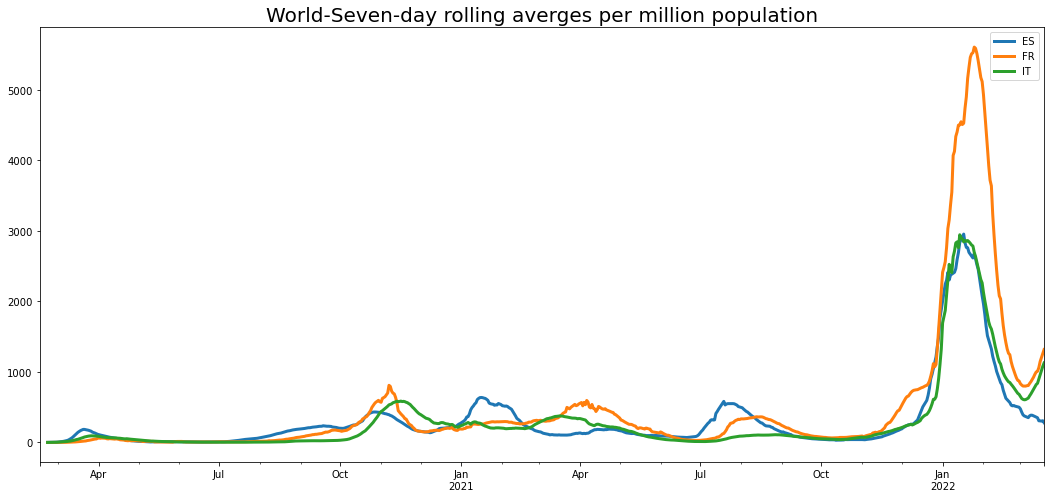

In [37]:
# Plot 7-day moving averge per million population
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data_all = world_cases_by_million.rolling(window=7).mean()
roll_data_all.plot(ax=ax, linewidth=3);
plt.title('World-Seven-day rolling averges per million population',fontsize=20);
#plt.savefig(f'./covid_data_update/us_rolling_avg_per_million_{day}.png');

Countries available: ['ES', 'FR', 'IT']



Choose country for rolling averge: 


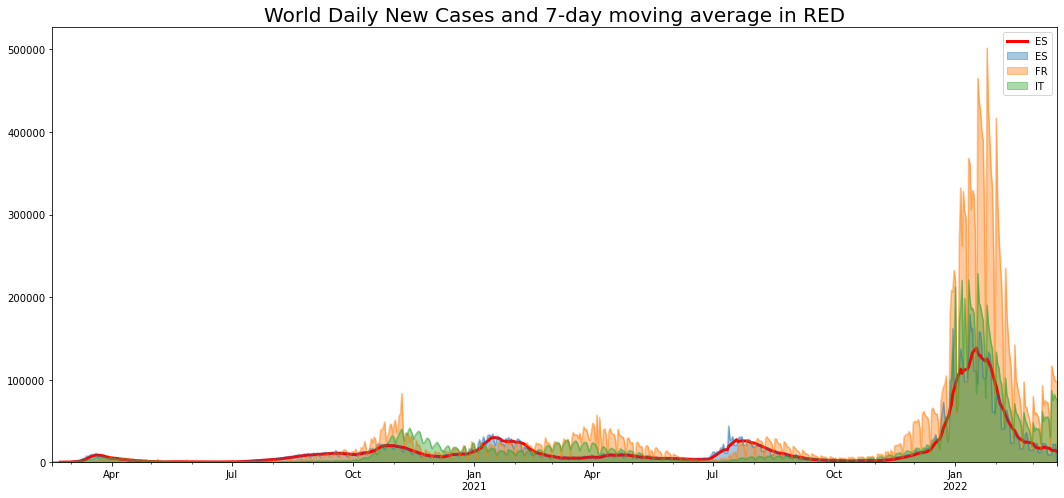

In [38]:
# Allows user to select the country for the rolling average
c_available = list(country.columns)
print(f'Countries available: {c_available}')
print()

snames = (list2string(c_available))

select_country = input('Choose country for rolling averge:') or c_available[0]
select_country = select_country.upper()

if select_country not in c_available:
    select_country = c_available[0]

# Plot Daily New Cases and 7-day moving averge
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data = country.loc[:,[select_country]].rolling(window=7).mean()


roll_data.plot(ax=ax, linewidth=3, color='r')
country.plot(kind='area',alpha=.4,ax=ax,stacked=False)
plt.title('World Daily New Cases and 7-day moving average in RED',fontsize=20);
# insert {snames} if desired 
plt.savefig(f'./covid_data_update/world_{day}.png');

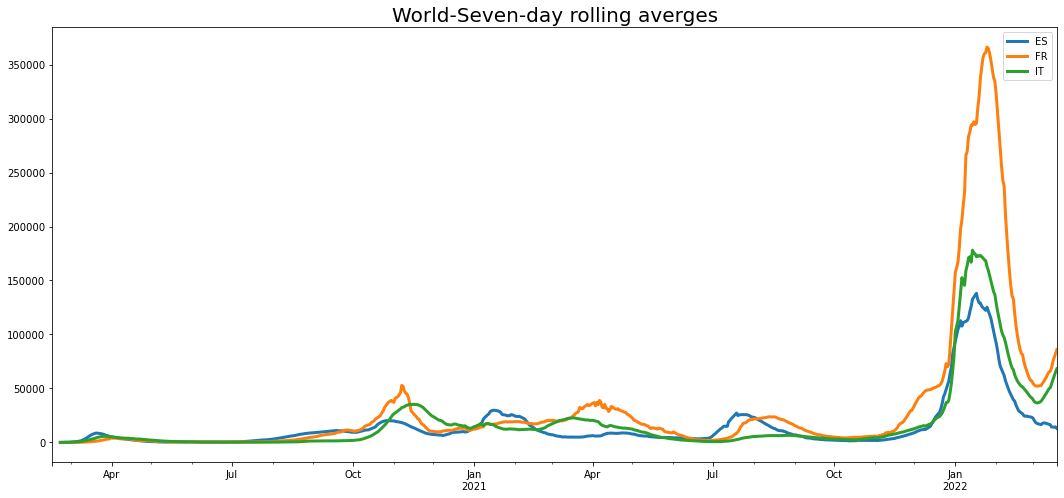

In [39]:
# Plot 7-day moving averge
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data_all = country.rolling(window=7).mean()
roll_data_all.plot(ax=ax, linewidth=3);
plt.title('World-Seven-day rolling averges',fontsize=20)
# insert {snames} if desired 
plt.savefig(f'./covid_data_update/world_rolling_avg_{day}.png');

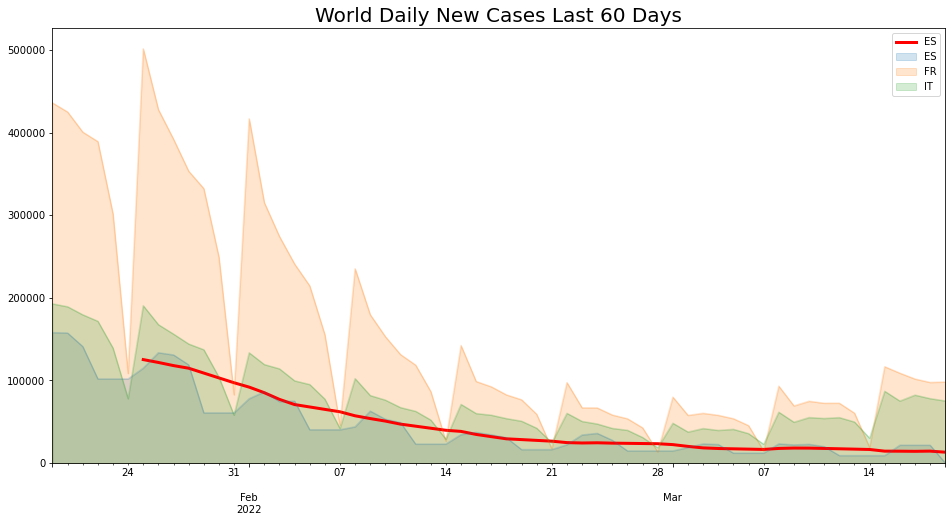

In [40]:
# Plot last 60 days
plt.close('all')
# Select last 60 days only
country_last60 = country.tail(60)

roll_data = country_last60.loc[:,[select_country]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
country_last60.plot(kind='area',alpha=.2,ax=ax,stacked=False);

plt.title('World Daily New Cases Last 60 Days',fontsize=20)
plt.savefig(f'./covid_data_update/world_{snames}_last_60_days_{day}.png');


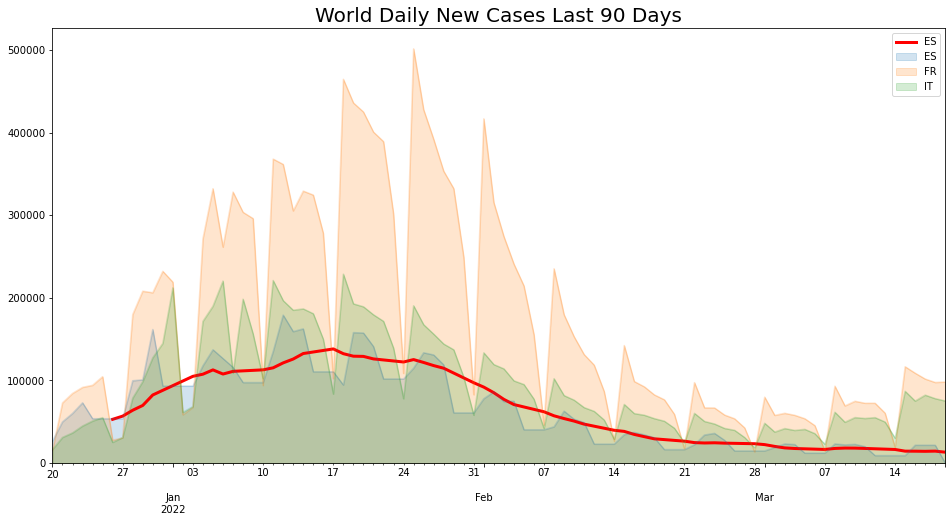

In [41]:
# Plot last 90 days
plt.close('all')
# Select last 90 days only
country_last90 = country.tail(90)

roll_data = country_last90.loc[:,[select_country]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
country_last90.plot(kind='area',alpha=.2,ax=ax,stacked=False);

plt.title('World Daily New Cases Last 90 Days',fontsize=20)
plt.savefig(f'./covid_data_update/world_{snames}_last_90_days_{day}.png');


In [42]:
# Daily New Cases in tabular format
pd.set_option('display.max_rows', 300)
pd.set_option('display.min_rows', 300)

In [43]:
# Note that new cases provided for Spain have a pattern of muliple days with exactly the same number
country.sort_index(ascending = False)

,ES,FR,IT
2022-03-19,0,98104,75173
2022-03-18,21533,97579,77994
2022-03-17,21532,101747,82222
2022-03-16,21532,108832,75041
2022-03-15,9015,116618,86867
2022-03-14,9017,18853,30026
2022-03-13,9017,60422,49684
2022-03-12,9017,72443,55018
2022-03-11,19849,72399,53971
2022-03-10,22615,74818,55064


### Save merged dataframes to csv

In [44]:
# Merge state and country dfs into one
world = state.merge(country,left_index=True,right_index=True,how='outer')
world = world.fillna(0).astype(int)

In [45]:
# Sorting the table with recent dates on the top
world_table = world.sort_index(ascending = False)

# Save to csv by uncommenting out the next line
# world_table.to_csv(f'./covid_data/world_table{day}.csv')
world_table.head(5)

,CA,IL,NY,ES,FR,IT
2022-03-19,727,0,2379,0,98104,75173
2022-03-18,4224,1388,2143,21533,97579,77994
2022-03-17,5588,1150,2327,21532,101747,82222
2022-03-16,2656,1031,1977,21532,108832,75041
2022-03-15,2280,1574,3305,9015,116618,86867


In [46]:
total_by_million = state_cases_by_million.merge(world_cases_by_million,left_index=True, right_index=True, how='outer')
total_by_million.tail()

,CA,IL,NY,ES,FR,IT
2022-03-15,58.0,123.0,164.0,193.0,1786.0,1437.0
2022-03-16,67.0,81.0,98.0,460.0,1667.0,1241.0
2022-03-17,141.0,90.0,115.0,460.0,1558.0,1360.0
2022-03-18,107.0,108.0,106.0,461.0,1494.0,1290.0
2022-03-19,18.0,0.0,118.0,0.0,1502.0,1244.0


### Weekly Sums

In [47]:
# Note that the last week may be only a partial unless this is executed at end of week
# End of week is Sunday, so this should be executed on Mondays
df1 = world.resample('w').sum()
df1.sort_index(ascending = False).head(10)

,CA,IL,NY,ES,FR,IT
2022-03-20,18460,5840,13696,82629,541733,427323
2022-03-13,31442,8274,11930,117582,456818,347314
2022-03-06,39110,9010,14299,117622,367994,261836
2022-02-27,64618,13047,15781,165064,402503,294804
2022-02-20,86382,17977,23438,191736,578002,364230
2022-02-13,177768,32222,37191,294805,950456,483730
2022-02-06,241260,52508,58506,454653,1700298,696690
2022-01-30,510648,85908,104021,721466,2365641,977375
2022-01-23,763057,185523,194626,865066,2520048,1184746
2022-01-16,825663,201843,386079,954178,2061166,1222234


### Custom graphs section

In [48]:
world.tail()
total_by_million.tail()

,CA,IL,NY,ES,FR,IT
2022-03-15,2280,1574,3305,9015,116618,86867
2022-03-16,2656,1031,1977,21532,108832,75041
2022-03-17,5588,1150,2327,21532,101747,82222
2022-03-18,4224,1388,2143,21533,97579,77994
2022-03-19,727,0,2379,0,98104,75173


,CA,IL,NY,ES,FR,IT
2022-03-15,58.0,123.0,164.0,193.0,1786.0,1437.0
2022-03-16,67.0,81.0,98.0,460.0,1667.0,1241.0
2022-03-17,141.0,90.0,115.0,460.0,1558.0,1360.0
2022-03-18,107.0,108.0,106.0,461.0,1494.0,1290.0
2022-03-19,18.0,0.0,118.0,0.0,1502.0,1244.0


In [49]:
import date_select as ds
start,stop = ds.date_maker()

 Select START date


START:	 2021-10-01 00:00:00
STOP:	 2022-03-20 00:00:00


Select custom STOP date? (y/n)   



START:	 2021-10-01 00:00:00
STOP:	 2022-03-20 00:00:00


In [50]:
world_cols = world.columns.to_list()
print (world_cols)
default_str = ' '.join(world_cols)

['CA', 'IL', 'NY', 'ES', 'FR', 'IT']


### Select custom states and countries

In [51]:
s_string = input('Enter any codes from the above list:') or default_str
print()

Enter any codes from the above list: 


In [52]:
s_string

'CA IL NY ES FR IT'

In [53]:
slist = scd.custom_list (s_string)

new_slist =[]
for item in slist:
    if item in world_cols:
        
        new_slist.append(item)
new_slist

['CA', 'IL', 'NY', 'ES', 'FR', 'IT']

In [54]:
if new_slist:
    df = world.loc[start:stop, new_slist]
    title ='Custom rolling averges'
    df.tail()
else:
    print('custom codes not available')

,CA,IL,NY,ES,FR,IT
2022-03-15,2280,1574,3305,9015,116618,86867
2022-03-16,2656,1031,1977,21532,108832,75041
2022-03-17,5588,1150,2327,21532,101747,82222
2022-03-18,4224,1388,2143,21533,97579,77994
2022-03-19,727,0,2379,0,98104,75173


In [55]:
if new_slist:
    df1 = total_by_million.loc[start:stop, new_slist]
    title1 ='Custom rolling averges by million'
    df1.tail()
else:
    print('custom codes not available')

,CA,IL,NY,ES,FR,IT
2022-03-15,58.0,123.0,164.0,193.0,1786.0,1437.0
2022-03-16,67.0,81.0,98.0,460.0,1667.0,1241.0
2022-03-17,141.0,90.0,115.0,460.0,1558.0,1360.0
2022-03-18,107.0,108.0,106.0,461.0,1494.0,1290.0
2022-03-19,18.0,0.0,118.0,0.0,1502.0,1244.0


<AxesSubplot:>

Text(0.5, 1.0, 'Custom rolling averges')

<AxesSubplot:>

Text(0.5, 1.0, 'Custom rolling averges by million')

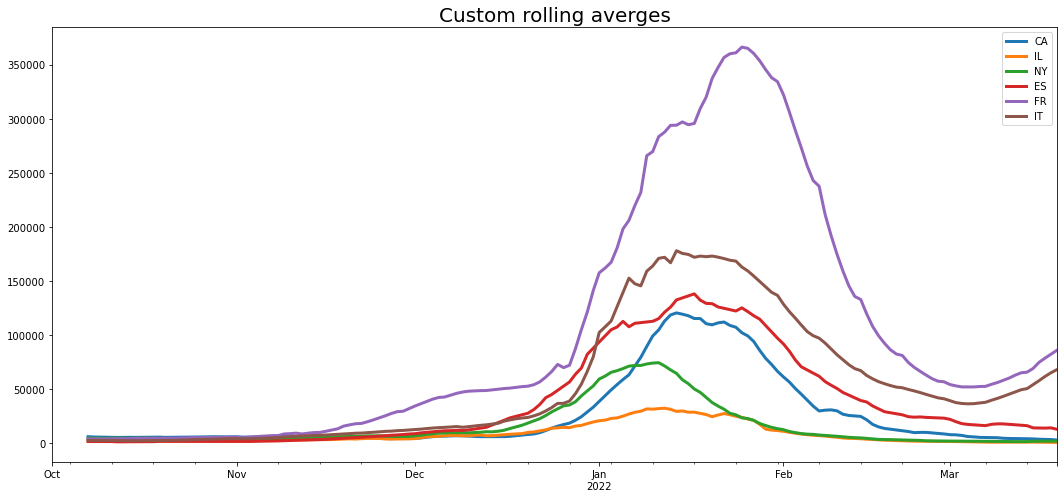

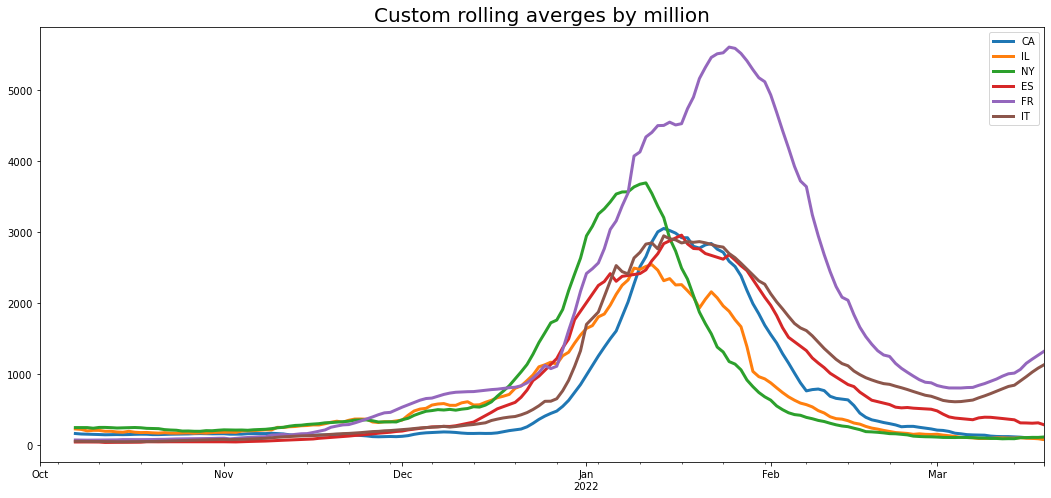

In [56]:
if new_slist:
    # Plot custom moving averge (default: 7 days) 
    plt.close('all')
    fig,ax = plt.subplots(1,1,figsize=(18,8))
    roll_data_all = df.rolling(window=7).mean()
    roll_data_all.plot(ax=ax, linewidth=3);
    plt.title(title,fontsize=20);
    #plt.savefig(f'./covid_data_update/us_rolling_avg_per_million_{day}.png');
    
    # Plot custom moving averge (default: 7 days) per million population
    fig,ax = plt.subplots(1,1,figsize=(18,8))
    roll_data_all = df1.rolling(window=7).mean()
    roll_data_all.plot(ax=ax, linewidth=3);
    plt.title(title1,fontsize=20);
    #plt.savefig(f'./covid_data_update/us_rolling_avg_per_million_{day}.png');

### Displays all updated graphs files

In [57]:
!ls covid_data_update

us_2022-03-20.png
us_CA_IL_NY_last_60_days_2022-03-20.png
us_CA_IL_NY_last_90_days_2022-03-20.png
us_rolling_avg_2022-03-20.png
world_2022-03-20.png
world_ES_FR_IT_last_60_days_2022-03-20.png
world_ES_FR_IT_last_90_days_2022-03-20.png
world_rolling_avg_2022-03-20.png


In [58]:
'''
commented out this cell - redundancy of displaying plots twice

!ls covid_data_update/*.png > flist_of_covid_png 

# Loop through the file flist and store filenames in png_list
with open('flist_of_covid_png') as f:
    png_str = f.read()
png_list = png_str.split('\n')[0:-1]

png_list

from IPython.display import Image

for file in png_list:    
    local = Image(file)
    local
'''

"\ncommented out this cell - redundancy of displaying plots twice\n\n!ls covid_data_update/*.png > flist_of_covid_png \n\n# Loop through the file flist and store filenames in png_list\nwith open('flist_of_covid_png') as f:\n    png_str = f.read()\npng_list = png_str.split('\n')[0:-1]\n\npng_list\n\nfrom IPython.display import Image\n\nfor file in png_list:    \n    local = Image(file)\n    local\n"

### tabla rasa

In [59]:
# this cell will delete all files created in todays session
!rm -rf covid_data_update

In [60]:
# Ensure helper files used have been removed
!rm -f covid_data/covid_text covid_data/flist_of_covid_png covid_data/temp.xlsx
!rm -f flist_of_covid_png